The goal of this notebook is to verify that you can load the checkpointed model from it's github repo and run it on a few test image samples and verify that the whole inference pipeline works.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

First, the imports:

In [2]:
%matplotlib inline
import sys
import numpy as np
import cv2 as cv
import tensorflow as tf
from models import resnet as resnet
import matplotlib.pyplot as plt
import pandas as pd
import os

 Helper functions

In [3]:
def _load_dictionary(dict_file):
    dictionary = dict()
    with open(dict_file, 'r') as lines:
        for line in lines:
            sp = line.rstrip('\n').split('\t')
            idx, name = sp[0], sp[1]
            dictionary[idx] = name
    return dictionary
# Load the labels:
# dictionary = _load_dictionary("ml2020_dictionary.txt")
# I generated these a priori

def preprocess(img):
    rawH = float(img.shape[0])
    rawW = float(img.shape[1])
    newH = 256.0
    newW = 256.0
    test_crop = 224.0 

    if rawH <= rawW:
        newW = (rawW/rawH) * newH
    else:
        newH = (rawH/rawW) * newW
    img = cv.resize(img, (int(newW), int(newH)))
    img = img[int((newH-test_crop)/2):int((newH-test_crop)/2)+int(test_crop),int((newW-test_crop)/2):int((newW-test_crop)/2)+int(test_crop)]
    img = ((img/255.0) - 0.5) * 2.0
    img = img[...,::-1]
    return img

Model declaration and weight restoration

In [4]:
images = tf.placeholder(dtype=tf.float32, shape=[None, 224, 224, 3])
net = resnet.ResNet(images, is_training=False)
net.build_model()

logit = net.logit
prob = tf.nn.softmax(logit)
prob_topk, pred_topk = tf.nn.top_k(prob, k=20)

# restore model
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement=False
sess = tf.Session(config=config)
saver = tf.train.Saver(tf.global_variables())
saver.restore(sess, "./checkpoints/model.ckpt")
print('Architecture details \n')
print(f'N_class:{net.num_classes},Stages: {net.stages}, N_filters: {net.filters}')

Instructions for updating:
keep_dims is deprecated, use keepdims instead
INFO:tensorflow:Restoring parameters from ./checkpoints/model.ckpt
Architecture details 

N_class:11166,Stages: [3, 4, 23, 3], N_filters: [256, 512, 1024, 2048]


In case you want generate the dictionary of labels on the spot:

In [5]:
url_ml='https://raw.githubusercontent.com/Tencent/tencent-ml-images/master/data/dictionary_and_semantic_hierarchy.txt'
df_ml=pd.read_csv(url_ml,delimiter='	')
print(df_ml.shape)
df_ml.head()
dictionary_ml = {}
N_class=df_ml.shape[0]
keys = range(N_class)
values = list(df_ml.loc[:,'category name'].values)
from tqdm.notebook import tqdm
for i in keys:
        dictionary_ml[i] = values[i]

# print(dictionary_ml)

(11166, 4)


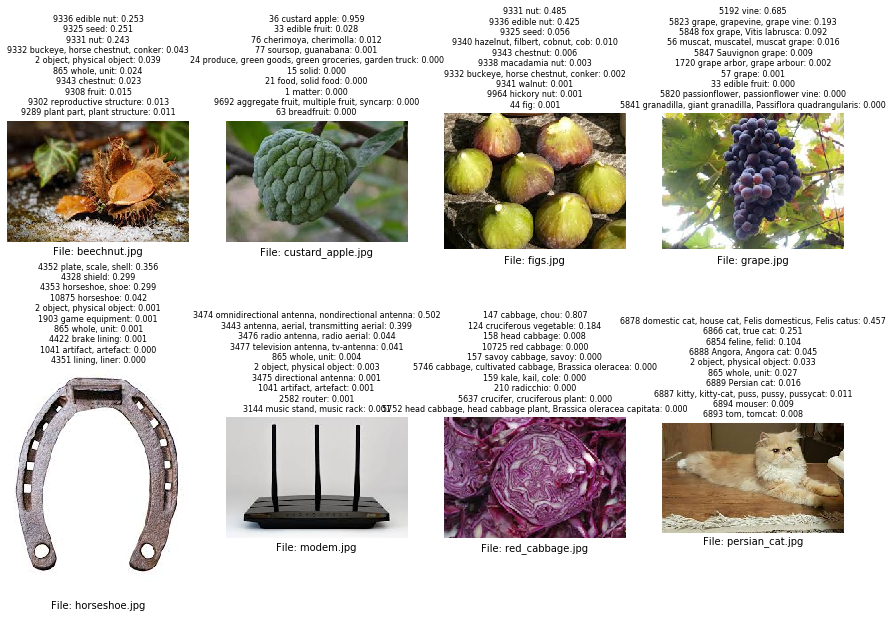

In [6]:
# Manual selection 
test_dir=os.getcwd()+'/ml_test/'
fig=plt.figure(figsize=(15,10))

for im_ind,im in enumerate(os.listdir(test_dir)):
    im=test_dir+im
    raw_img = cv.imread(im)
    img = preprocess(raw_img)
    logits, probs_topk, preds_topk = sess.run([logit, prob_topk, pred_topk], {images:np.expand_dims(img, axis=0)})
    preds_topk = np.squeeze(preds_topk)
#     print(preds_topk)
    names_topk = [dictionary_ml[i] for i in preds_topk]
    ax = fig.add_subplot(2,4,im_ind+ 1)
    ax.imshow(raw_img[...,::-1])
    plt.axis('Off')
    predictions = []
    for i, pred in enumerate(preds_topk[0:10]):
        predictions.append('%d %s: %.3f' % (pred, names_topk[i], probs_topk[0][i]))
        
    ax.set_title('\n'.join(predictions),fontsize=8)
    file_name=im.split('/')[-1]
    ax.text(0.5,-0.1,f'File: {file_name}',ha="center", 
         transform=ax.transAxes)
# plt.tight_layout()    
    